In [1]:
import pandas as pd
import json
import os
import pathlib
import warnings
from joblib import load
from mplsoccer import Pitch
from itertools import combinations_with_replacement
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

# Open the data

In [4]:
notebook_dir = pathlib.Path().absolute()
possession_chain_path = os.path.join(notebook_dir.parent,"wyscout-data", "possession-chain-data")

df = pd.DataFrame()

for i in range(11):
    file_name = 'possession_chains_England' + str(i+1) + '.json'
    path = os.path.join(possession_chain_path, file_name)
    with open(path) as f:
        data = json.load(f)
    df = pd.concat([df, pd.DataFrame(data)], ignore_index = True)

df = df.reset_index()
df.head()

,level_0,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,...,possesion_chain,possesion_chain_team,xG,shot_end,x0,c0,x1,c1,y0,y1
0,0,0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,...,0,1609,0.0,0,51.45,0.68,32.55,19.04,34.68,14.96
1,1,1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,...,0,1609,0.0,0,32.55,19.04,53.55,17.00,14.96,17.00
2,2,2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,...,0,1609,0.0,0,53.55,17.00,36.75,14.28,17.00,19.72
3,3,3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,...,0,1609,0.0,0,36.75,14.28,43.05,30.60,19.72,3.40
4,4,4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,...,0,1609,0.0,0,43.05,30.60,75.60,25.84,3.40,8.16


# Preparing variables for models

Combinations of starting and ending x-value and c (distance to middle of the pitch) to get their non-linear transformations.

Each transformation is a new column

In [7]:
# Model variables
var = ["x0", "x1", "c0", "c1"]

# Combinations
inputs = []
# One variable combinations
inputs.extend(combinations_with_replacement(var, 1))
# Two variable combinations
inputs.extend(combinations_with_replacement(var, 2))
# Three variable combinations
inputs.extend(combinations_with_replacement(var, 3))

# Make new columns
for i in inputs:
    # Columns length 1 already exist
    if len(i) > 1:
        # Column name
        column = ''
        x = 1
        for c in i:
            # Add column name to be x0x1c0 for example
            column += c
            # Multiply values in column
            x = x*df[c]

        # Create a new column in df
        df[column] = x
        # Add column to model variables
        var.append(column)

# Investigate 3 columns
df[var[-3:]].head(3)

,c0c0c1,c0c1c1,c1c1c1
0,8.804096,246.514688,6902.411264
1,6162.867200,5502.560000,4913.000000
2,4126.920000,3466.612800,2911.954752


# Calculating xT values for passes

- Logistic regression: kans dat een chain eindigt in een shot
- Linear regression: kans dat een chain die eindigt op een shot ook eindigt in een doelpunt
- Product van die twee kansen is ons xT

In [10]:
### TRAINING, it's not perfect ML procedure, but results in AUC 0.2 higher than Logistic Regression ###
#passes = df.loc[ df["eventName"].isin(["Pass"])]
#X = passes[var].values - note that this is different X, with data from BL
#y = passes["shot_end"].values
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123, stratify = y)
#xgb = XGBRegressor(n_estimators = 100, ccp_alpha=0, max_depth=4, min_samples_leaf=10,
#                       random_state=123)
#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(estimator = xgb, X = X_train, y = y_train, cv = 10, n_jobs = -1)
#print(np.mean(scores), np.std(scores))
#xgb.fit(X_train, y_train)
#print(xgb.score(X_train, y_train))
#y_pred = xgb.predict(X_test)
#print(xgb.score(X_test, y_test))

# Get passes
passes = df[df["eventName"].isin(["Pass"])]

# Init features and labels
X = passes[var].values
y = passes["shot_end"].values

# Load model
path_model = os.path.join(possession_chain_path, 'finalized_model.sav')
model = load(path_model)

# Predict probability of pass ending in a shot
y_pred_proba = model.predict_proba(X)[::, 1]
passes["shot_proba"] = y_pred_proba

# Get passes that ended in a shot
shots_ended = passes[passes["shot_end"] == 1]

# Init features and labels
X2 = shots_ended[var].values
y2 = shots_ended["xG"].values

# Train linear regression model on X2 and y2
lr = LinearRegression()
lr.fit(X2, y2)

# Use LR model to predict xG for X
y_pred = lr.predict(X)
passes["xG_pred"] = y_pred

# Calculate xT
passes["xT"] = passes["shot_proba"] * passes["xG_pred"]

# Show top 5
passes[["xG_pred", "shot_proba", "xT"]].head(5)


,xG_pred,shot_proba,xT
0,0.121099,0.030782,0.003728
1,0.108244,0.044363,0.004802
2,0.121571,0.046617,0.005667
3,0.118808,0.031972,0.003798
4,0.116028,0.052279,0.006066


# Plot of pass values

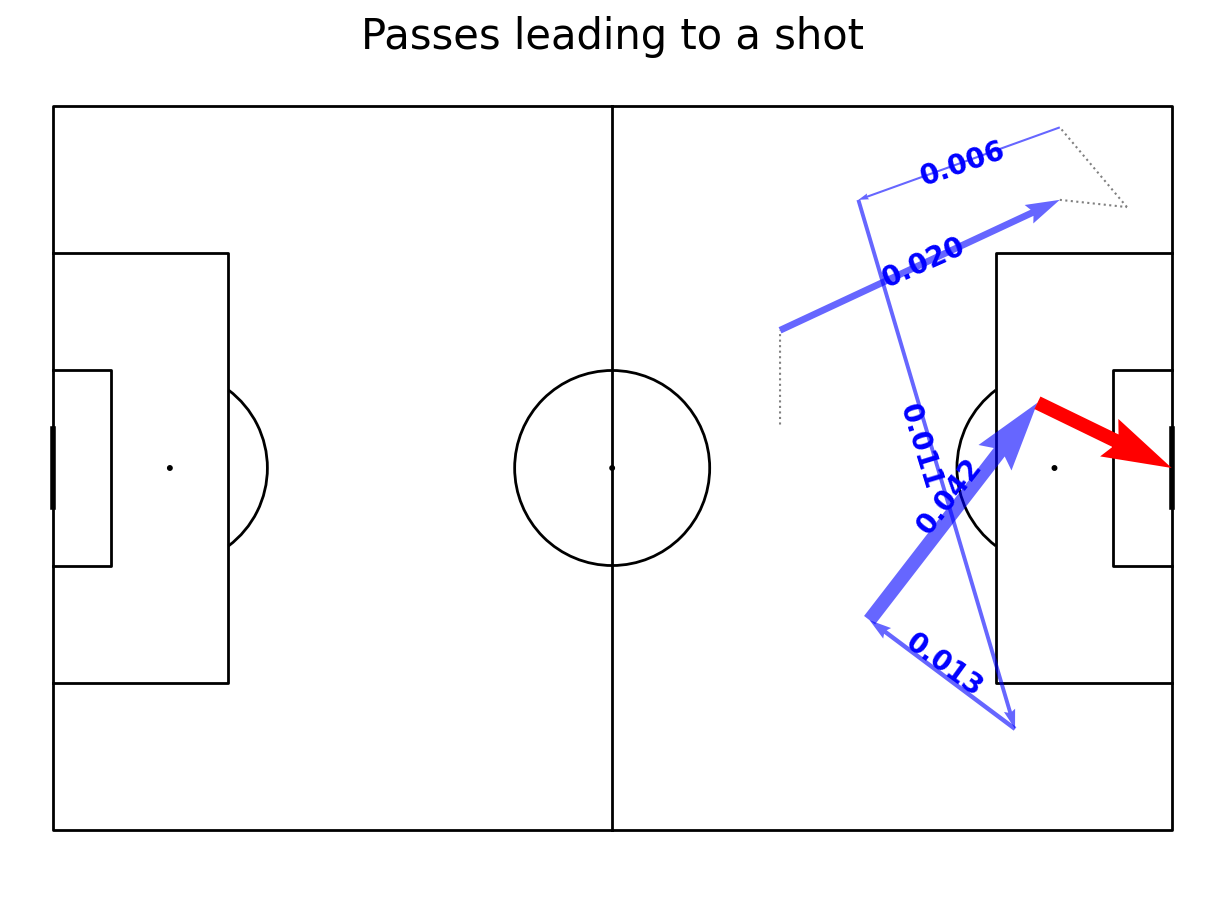

In [11]:
# Get a passing chain
chain = df[df["possesion_chain"] == 4]

# Get passes
passes_in = passes[passes["possesion_chain"] == 4]
max_value = passes_in["xT"].max()

# Get events that are not passes
not_pass = chain[chain["eventName"] != "Pass"].iloc[:-1]

# Shot is the last event in the chain
shot = chain.iloc[-1]

# Init plot
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Add size adjusted arrows
for i, row in passes_in.iterrows():
    # Get xT
    value = row["xT"]

    # Set line width based on xT
    line_width = value / max_value * 10

    # Get angle (for annotation)
    angle = np.arctan((row.y1-row.y0)/(row.x1-row.x0))*180/np.pi

    # Plot arrows
    pitch.arrows(row.x0, row.y0, row.x1, row.y1, alpha=0.6, width=line_width, zorder=2, color="blue", ax = ax["pitch"])

    # Annotate arrows with xT value
    ax["pitch"].text((row.x0+row.x1-8)/2, (row.y0+row.y1-4)/2, str(value)[:5], fontweight = "bold", color = "blue", zorder = 4, fontsize = 20, rotation = int(angle))

# Add shot
pitch.arrows(shot.x0, shot.y0, shot.x1, shot.y1, width=line_width, color = "red", ax=ax['pitch'], zorder =  3)

# Add other events
pitch.lines(not_pass.x0, not_pass.y0, not_pass.x1, not_pass.y1, color = "grey", lw = 1.5, ls = 'dotted', ax=ax['pitch'])

ax['title'].text(0.5, 0.5, 'Passes leading to a shot', ha='center', va='center', fontsize=30)
plt.show()

# Ranking players

In [14]:
# Group value actions by player
player_xT = passes[["playerId", "xT"]].groupby(["playerId"]).sum().reset_index()

# Get player data
players_path = os.path.join(notebook_dir.parent, "wyscout-data", "players.json")
player_df = pd.read_json(players_path, encoding='unicode-escape')
player_df.rename(columns = {'wyId':'playerId'}, inplace=True)
player_df["role"] = player_df.apply(lambda x: x.role["name"], axis = 1)
player_merge = player_df[["playerId", "shortName", "role"]]

# Merge player data with xT
player_xT = player_xT.merge(player_merge, on=["playerId"], how="left")

# Get minutes played
minutes_path = os.path.join(notebook_dir.parent, "wyscout-data", "minutes_played", "minutes_played_per_game_England.json")
with open(minutes_path) as f:
    minutes_per_game = json.load(f)

# Group players by minutes played
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"])["minutesPlayed"].sum().reset_index()

# Merge minutes with player_xT
player_xT = minutes.merge(player_xT, on=["playerId"], how="left")

# Filter players with more than 400 minutes
player_xT = player_xT.fillna(0)
player_xT = player_xT[player_xT["minutesPlayed"] > 400]

# Calculate xT per 90
player_xT["xT_per_90"] = player_xT["xT"] * 90 / (player_xT["minutesPlayed"])

# Get possession percentage data
possession_path = os.path.join(notebook_dir.parent, "wyscout-data", "minutes_played", "player_possesion_England.json")
with open(possession_path) as f:
    percentage_df = json.load(f)
percentage_df = pd.DataFrame(percentage_df)

# Merge possession percentage with player_xT
player_xT = player_xT.merge(percentage_df, on=["playerId"], how="left")

# Calculate adjusted xT per 90
player_xT["xT_adjusted_per_90"] = (player_xT["xT"] / player_xT["possesion"]) * 90 / (player_xT["minutesPlayed"])

# Show top 10 players
player_xT[["shortName", "xT_adjusted_per_90"]].sort_values(by="xT_adjusted_per_90", ascending=False).head(10)


,shortName,xT_adjusted_per_90
22,M. Özil,1.552911
27,Fàbregas,1.462536
250,E. Hazard,1.410102
30,A. Sánchez,1.396848
117,David Silva,1.338083
271,K. De Bruyne,1.273991
39,Philippe Coutinho,1.246540
68,P. Pogba,1.199696
351,O. Zinchenko,1.146892
58,Juan Mata,1.137875
